In [10]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import c
from IPython.display import display, Math

In [11]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
# lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
# lumapi = imp.load_source("lumapi", lumapiFile)
# interApi = lumapi.INTERCONNECT(hide = False)

In [12]:
interApi.expressioncheckoff()

In [13]:
# units
um = 1e-6
nm = 1e-9

L = 50*um
delta_L = np.array([552.82, 55.28, 27.64])*um

wavelength = 1550*um

# index
neff = 2.3531702
ng = 4.3458796

# cband = True
# # C Band simulation: 1520 - 1575 nm
# # L Band simulation: 1555 - 1635 nm
# if cband:
#     wvlngth_start = 1.520 * um
#     wvlngth_stop = 1.575 * um
# else:
#     wvlngth_start = 1.555 * um
#     wvlngth_stop = 1.635 * um

wvg_width = 450 * nm
wvg_height = 220 * nm

wvlngth_start = 1500 * nm
wvlngth_stop = 1600 * nm

# Add Devices  

In [14]:
interApi.switchtolayout()
interApi.select('ONA')
interApi.delete()

# ONA

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.set('number of input ports', 2)
interApi.set('input parameter', 2)
interApi.set('start frequency', c/wvlngth_start)
interApi.set('stop frequency', c/wvlngth_stop)

## $FSR(\lambda) = 1nm$

In [15]:
interApi.switchtolayout()
interApi.select('coupler_1')
interApi.delete()
interApi.select('coupler_2')
interApi.delete()
interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

# Waveguide

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler_1')

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler_2')

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', 'wg_1')
interApi.set('wg_length', L)
interApi.set('wg_width', wvg_width)


interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', 'wg_2')
interApi.set('wg_length', L + delta_L[0])
interApi.set('wg_width', wvg_width)

In [16]:
#positions
interApi.setposition('ONA', 0, -400)
interApi.setposition('wg_1', 0,-100)
interApi.setposition('wg_2', 0, 400)
interApi.setposition('coupler_1', -250, 50)
interApi.setposition('coupler_2', 600, 50)

In [17]:
# connection

interApi.connect("ONA", "output", "coupler_1", "opt_1")
interApi.connect("coupler_1", "opt_3", "wg_1", "port 1")
interApi.connect("coupler_1", "opt_4", "wg_2", "port 1")
interApi.connect("wg_1", "port 2", "coupler_2", "opt_1")
interApi.connect("wg_2", "port 2", "coupler_2", "opt_2")
interApi.connect("coupler_2", "opt_3", "ONA", "input 1")
interApi.connect("coupler_2", "opt_4", "ONA", "input 2")

1.0

In [18]:
interApi.run()

C:\Users\alves\AppData\Local\Temp\ipykernel_15276\2486749022.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1550, -32, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)


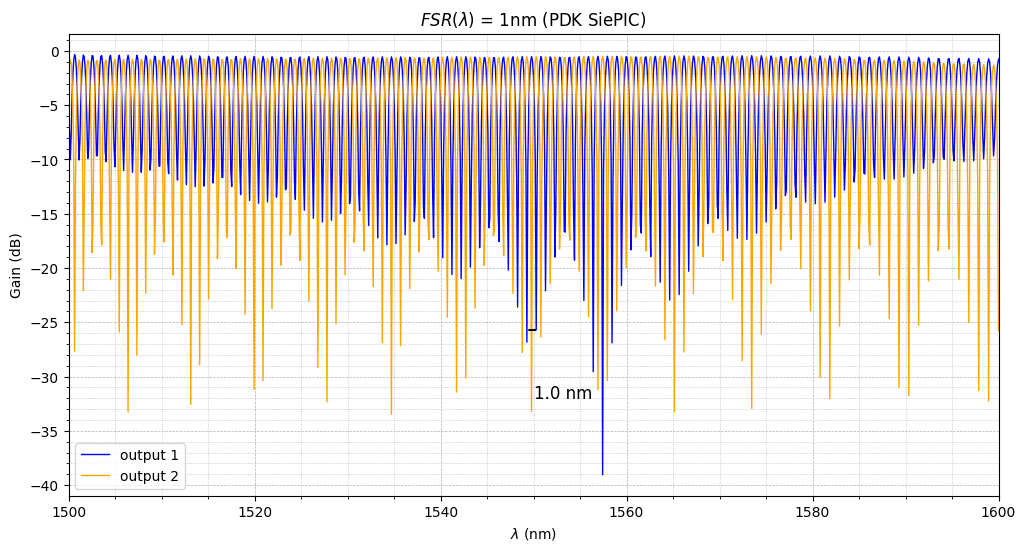

In [19]:
gain = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain['wavelength']
gain = gain["'TE' gain (dB)"]

gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2['wavelength']
gain_2 = gain_2["'TE' gain (dB)"]

min_indices, _ = find_peaks(-np.array(gain))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[47:49]  
    x_min_1, x_min_2 = wavelength_1[min_1] / nm, wavelength_1[min_2] / nm
    y_min = gain[min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_1 / nm, gain, lw=1, label='output 1', color='blue')
    plt.plot(wavelength_2 / nm, gain_2, lw=1, label='output 2', color='orange')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1550, -32, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
    plt.title('$FSR(\lambda)$ = 1nm (PDK SiePIC)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_1nm_PDK', bbox_inches='tight')
    plt.show()

In [20]:
FSR_1_1nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_1nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_1nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_1nm["'TE' free spectral range (m)"])

wavelength_2 = np.array(FSR_2_1nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_1nm["'TE' free spectral range (m)"])  

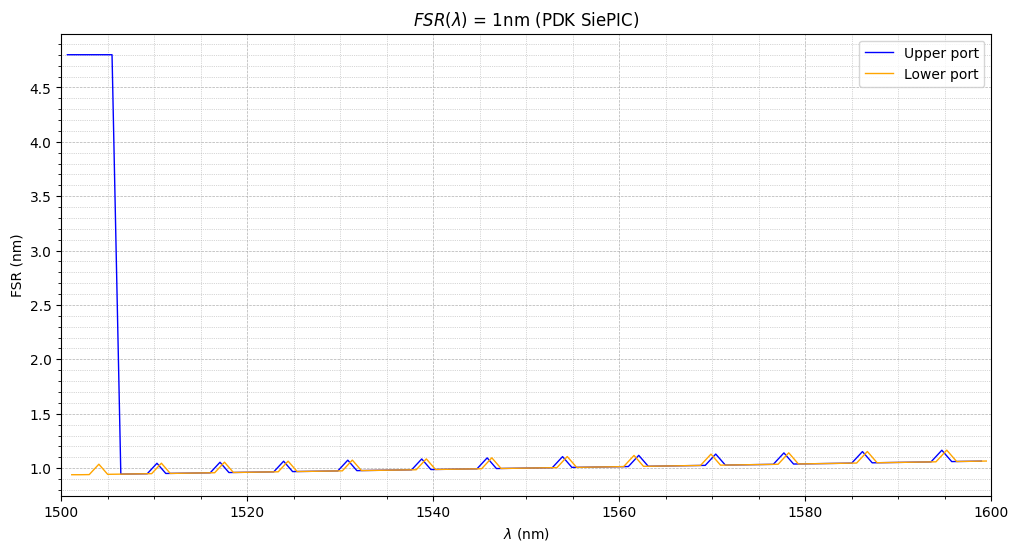

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Upper port', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Lower port', color='orange')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 1nm (PDK SiePIC)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1nm_x_wvlength', bbox_inches='tight')
plt.show()

## $FSR(\lambda)=10nm$

In [22]:
interApi.switchtolayout()
interApi.select('wg_2')
interApi.delete()

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', 'wg_2')
interApi.set('wg_length', L + delta_L[1])
interApi.set('wg_width', wvg_width)

In [23]:
#positions
interApi.setposition('wg_2', 0, 400)

In [24]:
# connection

interApi.connect("coupler_1", "opt_4", "wg_2", "port 1")
interApi.connect("wg_2", "port 2", "coupler_2", "opt_2")

1.0

In [25]:
interApi.run()

C:\Users\alves\AppData\Local\Temp\ipykernel_15276\783099571.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1540, -28, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)


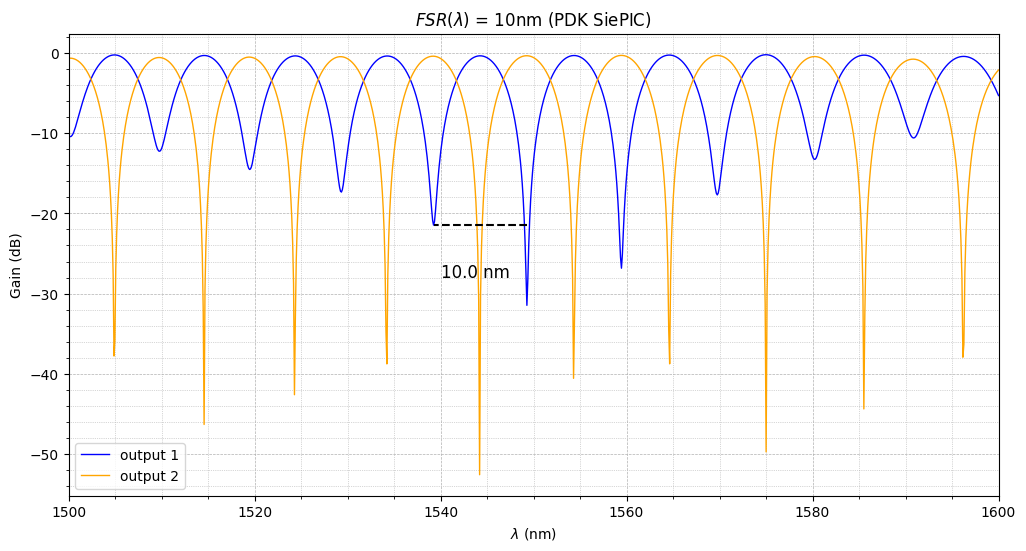

In [26]:
gain = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain['wavelength']
gain = gain["'TE' gain (dB)"]

gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2['wavelength']
gain_2 = gain_2["'TE' gain (dB)"]

min_indices, _ = find_peaks(-np.array(gain))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[4:6]  
    x_min_1, x_min_2 = wavelength_1[min_1] / nm, wavelength_1[min_2] / nm
    y_min = gain[min_2]

    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_1 / nm, gain, lw=1, label='output 1', color='blue')
    plt.plot(wavelength_2 / nm, gain_2, lw=1, label='output 2', color='orange')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1540, -28, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
    plt.title('$FSR(\lambda)$ = 10nm (PDK SiePIC)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_10nm_PDK', bbox_inches='tight')
    plt.show()

In [27]:
FSR_1_10nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_10nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_10nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_10nm["'TE' free spectral range (m)"])

wavelength_2 = np.array(FSR_2_10nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_10nm["'TE' free spectral range (m)"])  

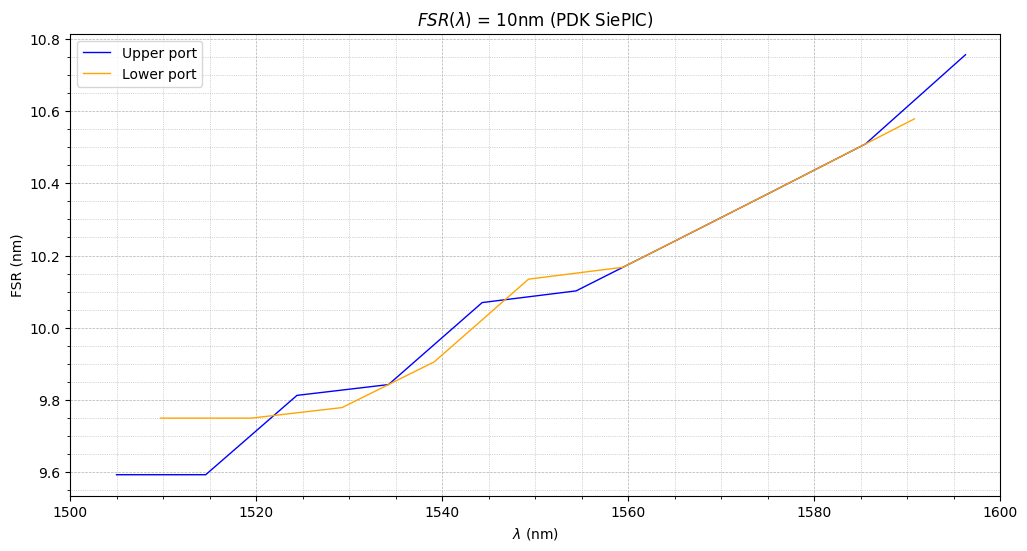

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Upper port', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Lower port', color='orange')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 10nm (PDK SiePIC)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1nm_x_wvlength', bbox_inches='tight')
plt.show()

## $FSR(\lambda)=20nm$

In [29]:
interApi.switchtolayout()
interApi.select('wg_2')
interApi.delete()

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', 'wg_2')
interApi.set('wg_length', L + delta_L[2])
interApi.set('wg_width', wvg_width)

In [30]:
#positions
interApi.setposition('wg_2', 0, 400)

In [31]:
# connection

interApi.connect("coupler_1", "opt_4", "wg_2", "port 1")
interApi.connect("wg_2", "port 2", "coupler_2", "opt_2")

1.0

In [32]:
interApi.run()

C:\Users\alves\AppData\Local\Temp\ipykernel_15276\4071180804.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1535, -26, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)


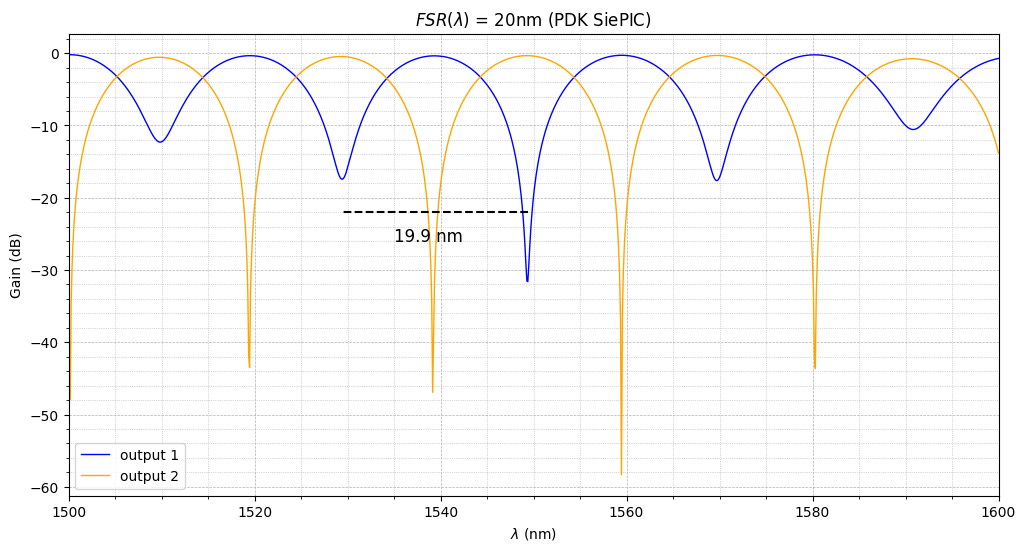

In [33]:
gain = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain['wavelength']
gain = gain["'TE' gain (dB)"]

gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2['wavelength']
gain_2 = gain_2["'TE' gain (dB)"]

min_indices, _ = find_peaks(-np.array(gain))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[2:4]  
    x_min_1, x_min_2 = wavelength_1[min_1] / nm, wavelength_1[min_2] / nm
    y_min = gain[min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_1 / nm, gain, lw=1, label='output 1', color='blue')
    plt.plot(wavelength_2 / nm, gain_2, lw=1, label='output 2', color='orange')

    plt.hlines(y=-22, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1535, -26, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    plt.legend(loc='best')

    plt.title('$FSR(\lambda)$ = 20nm (PDK SiePIC)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.savefig('FSR_20nm_PDK', bbox_inches='tight')
    plt.show()

In [34]:
FSR_1_20nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_20nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_20nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_20nm["'TE' free spectral range (m)"])

wavelength_2 = np.array(FSR_2_20nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_20nm["'TE' free spectral range (m)"])  

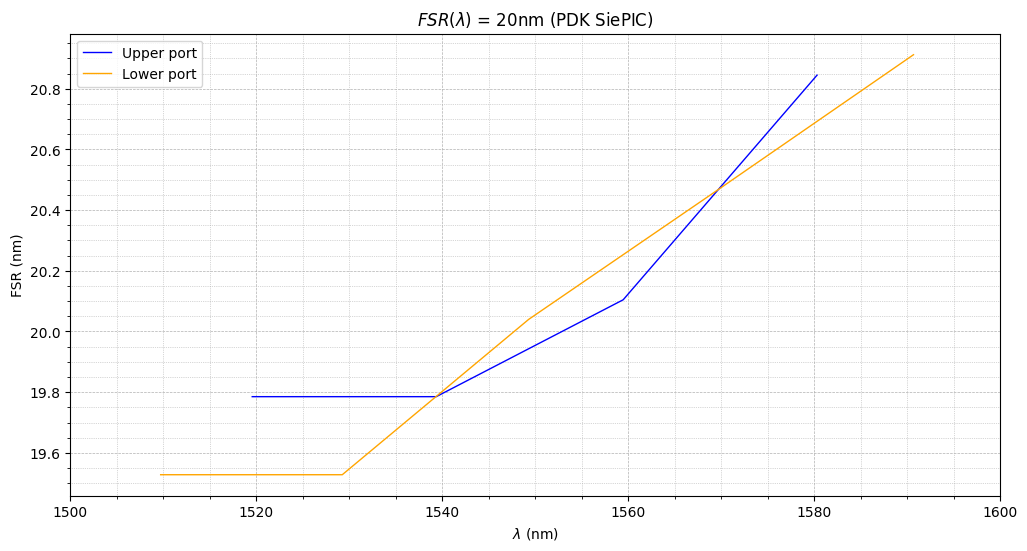

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Upper port', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Lower port', color='orange')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 20nm (PDK SiePIC)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1nm_x_wvlength', bbox_inches='tight')
plt.show()

# All cases

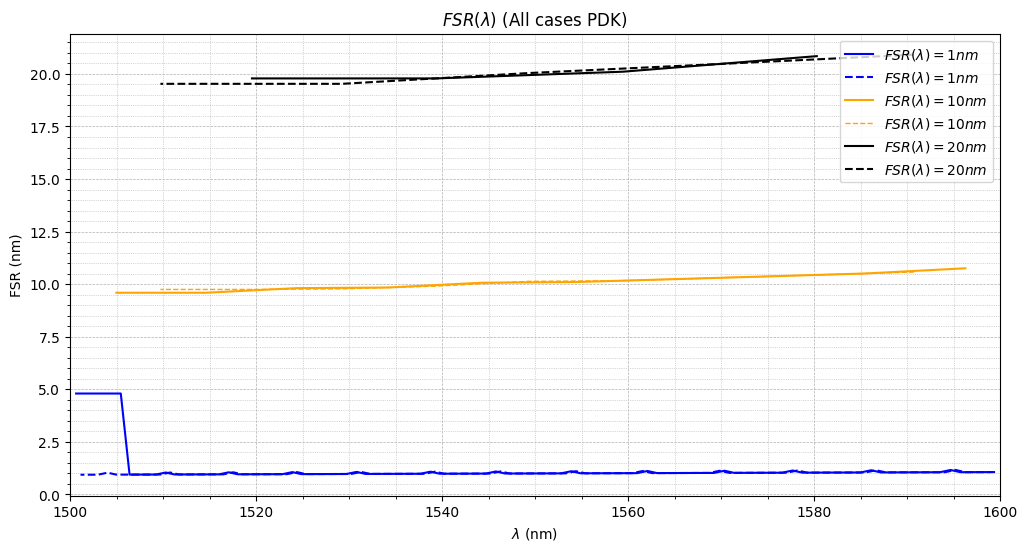

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(FSR_1_1nm['wavelength'] / nm, FSR_1_1nm["'TE' free spectral range (m)"]/nm, lw=1.5, label='$FSR(\lambda)=1nm$', color='blue')
plt.plot(FSR_2_1nm['wavelength'] / nm, FSR_2_1nm["'TE' free spectral range (m)"]/nm, lw=1.5, ls = '--', label='$FSR(\lambda)=1nm$', color='blue')

plt.plot(FSR_1_10nm['wavelength'] / nm, FSR_1_10nm["'TE' free spectral range (m)"]/nm, lw=1.5, label='$FSR(\lambda)=10nm$', color='orange')
plt.plot(FSR_2_10nm['wavelength'] / nm, FSR_2_10nm["'TE' free spectral range (m)"]/nm, lw=1, ls = '--', label='$FSR(\lambda)=10nm$', color='orange')

plt.plot(FSR_1_20nm['wavelength'] / nm, FSR_1_20nm["'TE' free spectral range (m)"]/nm, lw=1.5, label='$FSR(\lambda)=20nm$', color='black')
plt.plot(FSR_2_20nm['wavelength'] / nm, FSR_2_20nm["'TE' free spectral range (m)"]/nm, lw=1.5, ls = '--', label='$FSR(\lambda)=20nm$', color='black')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ (All cases PDK)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1_10_20nm_x_wvlength', bbox_inches='tight')
plt.show()

In [37]:
import pickle

# Salvar a variável em um arquivo
with open('FSR_1_1nm.pkl', 'wb') as f:
    pickle.dump(FSR_1_1nm, f)

with open('FSR_1_10nm.pkl', 'wb') as f:
    pickle.dump(FSR_1_10nm, f)

with open('FSR_1_20nm.pkl', 'wb') as f:
    pickle.dump(FSR_1_20nm, f)